GoogLeNet借鉴了NiN的思想，还是打包成块，然后用1*1的卷积代替了全连接层，下面看看Inception块：
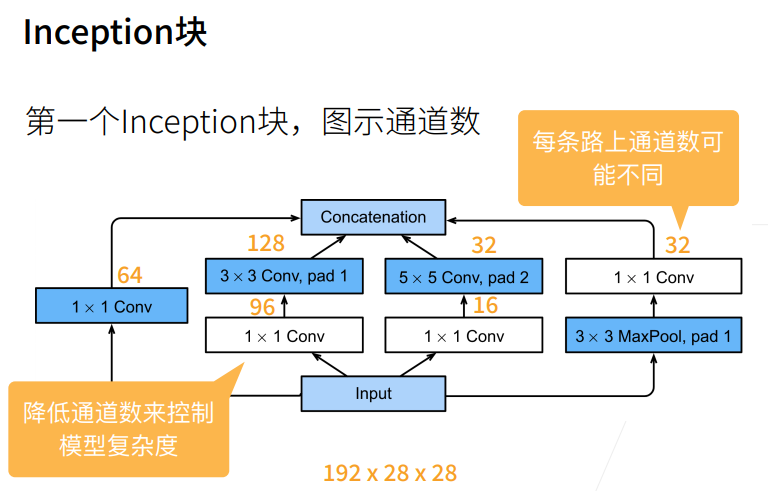

In [1]:
# 解决内核挂掉的问题
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs): 
        """c1, c2, c3, c4就是Inception块中那四个并行的卷积的通道数"""
        super(Inception, self).__init__(**kwargs) # 继承父类属性
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1) # 第一个并行模块的卷积1*1
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1) # 第二个并行模块的第一个卷积1*1
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1) # 第二个并行模块的第二个卷积3*3
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1) # 第三个并行模块的第一个卷积1*1
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2) # 第三个并行模块的第二个卷积5*5
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1) # 第四个并行模块的第一个卷积3*3
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1) # 第四个并行模块的第一个卷积1*1

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1) # 在通道那里把这四个串联起来

GoogLeNet模型，下面是以池化层划分为stage：
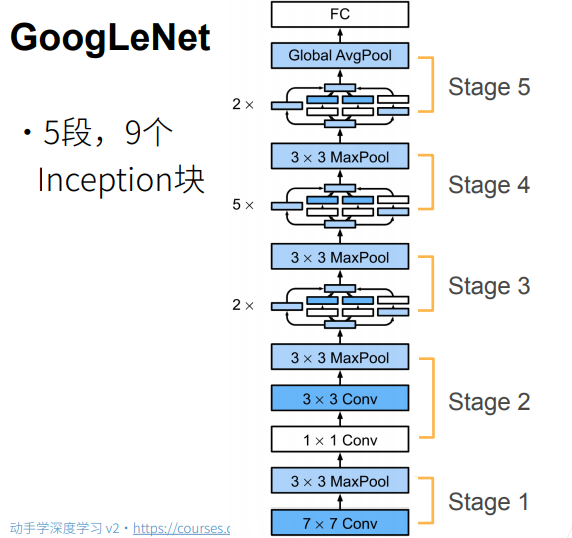

In [2]:
# 第一个stage,一个7*7的卷积、一个3*3的最大池化
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2,
                                           padding=1))

# 第二个stage,1个1*1卷积、1个3*3卷积、1个3*3最大池化
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# 第三个stage,2个inception块，1个3*3最大池化
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# 第四个stage,5个inception块，1个3*3最大池化
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# 第五个stage,2个inception块，1个1*1平均池化、最后除0维度，其他维度拉平
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10)) # 最后接一个全连接的线性层，输出为10类

为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96。打印看看每个stage输出的形状

In [3]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


训练模型

loss 0.249, train acc 0.905, test acc 0.893
1368.9 examples/sec on cuda:0


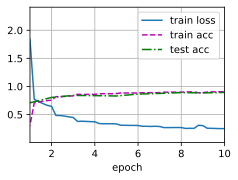

In [4]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())